# Create a Custom Pytorch Image Dataset

In this practical, we will be creating a custom image dataset for a classification problem, using a folder of images downloaded from Google Images. Inside the `Images` directory there are four subfolders, each corresponding to a type of animal. These will form the classes of our classifier, with the examples being the images contained in the subfolders.


In [5]:
# @title # Run the following cell to download the necessary files for this practical. { display-mode: "form" }
# @markdown Don't worry about what's in this collapsed cell

import os
import zipfile
import urllib.request

if not os.path.exists('data'):
    os.makedirs('data')

if not os.path.exists('data/images'):
    print('Downloading images.zip...')
    urllib.request.urlretrieve(
        'https://s3-eu-west-1.amazonaws.com/aicore-portal-public-prod-307050600709/practicals_files/6aefa2cd-3dc9-402d-b144-7e2c985a1168/images.zip', 'data/images.zip')
    print("Extracting iamges...")
    with zipfile.ZipFile('data/images.zip', 'r') as zip_ref:
        zip_ref.extractall('data/')
    os.remove('data/images.zip')

print('Files are downloaded.')


Files are downloaded.


In [6]:
# Run this code to import the necessary libraries.
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
import torch


Write a function to get the list of class names. The class names are the same as the subfolders of the `Images/` directory. The function should return a list of class names as strings.


In [7]:
def get_class_names():
    return [folder
            for folder in os.listdir('data/images/')
            if not folder.startswith('.')
            ]


animals_list: list[str] = get_class_names()
print(animals_list)


['crab', 'frog', 'horse', 'owl']


Next we will create a class called "Animal" which will collect all the images from a given class.


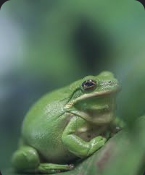

In [8]:
class Animal:

    name: str = None  # Name of an animal
    image_paths: str = None  # A list of paths of all images of an animal from the dataset.

    def __init__(self, animal_name: str):
        self.images = [f"data/images/{animal_name}/{path}"
                       for path in os.listdir(f"data/images/{animal_name}")
                       if not path.startswith('.')]
        self.name = animal_name

    def show(self) -> Image.Image:
        """Returns a random image of an animal

        Returns:
            Image: An `Image` object
        """
        file = random.choice(self.images)
        return Image.open(file)


frog = Animal('frog')
frog.show()


Now we need to create an encoder and decoder dictionary. These should map the class names to the integer class labels we will be using. Use dictionary comprehension to create these variables.


In [9]:
# Create your encoder. The keys should be the class name, and the values the label eg. {'frog': 0}
encoder = {}
# Import your decoder code. It should be the inverse of the encoder.
decoder = {}

for i, animal in enumerate(animals_list):
    encoder[animal] = i
    decoder[i] = animal

print(f"Encoder: {encoder}")
print(f"Decoder: {decoder}")


Encoder: {'crab': 0, 'frog': 1, 'horse': 2, 'owl': 3}
Decoder: {0: 'crab', 1: 'frog', 2: 'horse', 3: 'owl'}


Next, we need to create an image transform. This can be achieved using the `transforms` module from the `Torchvision` library. We will need to add transforms to resize the image and convert it to a `pytorch` tensor. You can read the docs for the `transforms` module to find the syntax for this.


In [10]:
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),      # Resize the image to 256 x 256 pixels.
    transforms.ToTensor(),              # Convert the image to a pytorch tensor.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Now we can put it all together into a dataset class that inherits from `torch.utils.Dataset`.

1. Inside the class constructor:

- Create an attribute called `self.animals` and assign it by calling the pre-defined `get_classes` method.
- Add the code from the encoder and decoder you defined above, assigning them to attributes called `self.encoder` and `self.decoder`.
- Complete the code inside the `for` loop, extending the attribute `self.images` by adding the image filepaths from each class.

2. Now define the second crucial method of the dataset class: `__getitem__`. This needs to take in an index of your dataset and return the features and label corresponding to that index. Your code should:

- Find the image filepath corresponding to the example index.
- Split the filepath on the `/` delimiters to get the class label.
- Use the encoder dictionary to get the image label.
- Read in the image file associated with the filepath as a PIL image.
- Apply the image transform.
- Return the image and label

3. Define the `__len__` method.


In [38]:
class AnimalsDataset(Dataset):
    """Example images of different types of animal"""

    animals: list[Animal] = None
    encoder: dict = None
    decoder: dict = None
    image_paths: list[str] = None
    transform: transforms.Compose | torch.nn.Module = None

    def __init__(self, transform, path="data/images"):
        self.animals = list(self.get_classes(path).values())
        self.encoder = encoder.copy()
        self.decoder = decoder.copy()
        self.transform = transform
        
        self.image_paths = []
        for animal in self.animals:
            self.image_paths += animal.images
    
    def get_classes(self, path: str) -> dict[str, Animal]:
        """Returns a `dict` that contains animal types

        Args:
            path (str): path where images are stored

        Returns:
            dict[str, Animal]: name of an animal and the corresponding `Animal` object
        """
        animal_map = {}
        animal_filepaths = [folder for folder in os.listdir(path)
                            if not folder.startswith('.')
                            ]
            
        # print(cities)
        for animal_name in animal_filepaths:
            animal_map[animal_name] = Animal(animal_name)
        return animal_map

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Returns a single image and its label as an integer value.

        Args:
            idx (int): index of the item requested
        """
        path: str = self.image_paths[idx]
        img: Image.Image = Image.open(path)
        img: torch.Tensor = self.transform(img)

        label: str = path.split('/')[-2]
        label: int = self.encoder[label]
        label: torch.Tensor = torch.tensor(label).resize(1)

        return img, label


Finally we can test that our dataset works by returning an example sample of the dataset, and printing the length of the dataset.


In [39]:
# Create an instance of AnimalsDataset
dataset = AnimalsDataset(data_transform)

# Generate an example sample of features and label, and print the shape of each.
# ! DataSet.__getitem__ 
example_features, example_label = next(iter(dataset))
print(f"Example features shape: {example_features.shape}")
print(f"Example label shape: {example_label.shape}")

# Print the length of the dataset.
print(f"Dataset size: {len(dataset)}")

Example features shape: torch.Size([3, 256, 256])
Example label shape: torch.Size([1])
Dataset size: 178
